# Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines.plotting import plot_lifetimes      # Lifeline package for the Survival Analysis
from lifelines.utils import to_long_format

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter 
from lifelines.utils import add_covariate_to_timeline
from lifelines.utils import covariates_from_event_matrix


%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


# Original Dataset

> Variable | Definition

> MMMM-YY | Reporting Date (Monthly)

> Emp_ID | Unique id for employees

> Age | Age of the employee

> Gender | Gender of the employee

> City | City Code of the employee

> Education_Level | Education level : Bachelor, Master or College

> Salary | Salary of the employee

> Dateofjoining | Joining date for the employee

> LastWorkingDate | Last date of working for the employee

> Joining Designation | Designation of the employee at the time of joining

> Designation | Designation of the employee at the time of reporting

>Total_Business_Value | The total business value acquired by the employee in a month (negative business indicates cancellation/refund of sold insurance policies)

>Quarterly Rating | Quarterly rating of the employee: 1,2,3,4 (higher is better)

## details of categorical columns:


Column Name:: gender, dtype: int64
-----------------------------
having 2 unique values

 Gender  |  Count
---------------   |   -----------
Male     | 1404
Female   |  977

Column Name:: city, dtype: int64
-----------------------------
having 29 unique values

City Name | Counts----- | City Name | Counts-----| City Name | Counts
------------ | ------------- | ------------ | -------------|------------ | -------------
C20   | 152    |    C15   | 101    |    C29   |  96     |   C26     93
C27   |  89    |    C8    |  89    |    C10   |  86     |   C16     84
C3    |  82    |    C22   |  82    |    C28   |  82     |   C12     81
C1    |  80    |    C5    |  80    |    C14   |  79     |   C21     79
C6    |  78    |    C4    |  77    |    C7    |  76     |   C9      75
C23   |  74    |    C25   |  74    |    C24   |  73     |   C19     72
C2    |  72    |    C17   |  71    |    C13   |  71     |   C18     69
C11   |  64


Column Name:: education_level, dtype: int64
-----------------------------
having 3 unique values

 education_level  |  Count
---------------   |   -----------
Master   |   802
Bachelor |   795
College  |   784

Column Name:: issurvived, dtype: int64
-----------------------------
having 2 unique values

`
0 is for observed i.e, event occured and employee left the company
and 1 for censored i.e, employee was still with the company till 2017 December
`

 issurvived  |  Count
---------------   |   -----------
0  |  1616
1  |   765

Column Name:: joining_designation, dtype: int64
----------------------------
having 5 unique values

 joining_designation  |  Count
---------------   |   -----------
1  |  1026
2  |   815
3  |   493
4  |    36
5  |    11


# Loading and processing data

In [2]:
train_data=pd.read_csv("train_MpHjUjU.csv")

In [3]:
train_data["MMM-YY"]=pd.to_datetime(train_data["MMM-YY"],format="%Y-%m-%d")
train_data["Dateofjoining"]=pd.to_datetime(train_data["Dateofjoining"],format="%Y-%m-%d")
train_data["LastWorkingDate"]=pd.to_datetime(train_data["LastWorkingDate"],format="%Y-%m-%d")

In [109]:
# train_data

In [5]:
train_data_dict=train_data.to_dict()
a=train_data_dict["Emp_ID"]

In [6]:
last_rows_of_train_data=dict([(value, key) for key, value in a.items()])

In [7]:
train_data

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,2017-08-01,2788,30,Male,C27,Master,70254,2017-06-08,NaT,2,2,740280,3
19100,2017-09-01,2788,30,Male,C27,Master,70254,2017-06-08,NaT,2,2,448370,3
19101,2017-10-01,2788,30,Male,C27,Master,70254,2017-06-08,NaT,2,2,0,2
19102,2017-11-01,2788,30,Male,C27,Master,70254,2017-06-08,NaT,2,2,200420,2


In [8]:
cleaned_train_dict={"emp_id":[],"age":[],"gender":[],"city":[],"education_level":[],"salary":[],"avg_salary":[],"dateofjoining":[],
                    "lastworking_date":[],"survival_days":[],"left":[],"joining_designation":[],"designation":[],
                    "average_business_value":[],"total_business_val":[],"total_quarter_rating":[]}
prev=0
for i in last_rows_of_train_data:
    if i==1:
        low=0
    else:
        low=last_rows_of_train_data[prev]+1
    stdt=train_data.iloc[last_rows_of_train_data[i],7]
    endt=train_data.iloc[last_rows_of_train_data[i],8]
    cleaned_train_dict["emp_id"].append(i)
    cleaned_train_dict["age"].append(train_data.iloc[last_rows_of_train_data[i],2])
    cleaned_train_dict["gender"].append(train_data.iloc[last_rows_of_train_data[i],3])
    cleaned_train_dict["city"].append(train_data.iloc[last_rows_of_train_data[i],4])
    cleaned_train_dict["education_level"].append(train_data.iloc[last_rows_of_train_data[i],5])
    cleaned_train_dict["salary"].append(list(train_data.iloc[list(range(low,last_rows_of_train_data[i]+1)),6]))
    cleaned_train_dict["avg_salary"].append(train_data.iloc[list(range(low,last_rows_of_train_data[i]+1)),6].mean())
    cleaned_train_dict["dateofjoining"].append(stdt)
    cleaned_train_dict["lastworking_date"].append(endt)
#     cleaned_train_dict["survival_days"].append(endt-stdt)
    if pd.isna(endt):
        cleaned_train_dict["survival_days"].append(np.timedelta64((pd.Timestamp("2018-01-01")-stdt),'D').astype("float64"))
        cleaned_train_dict["left"].append(0)
    else:
        cleaned_train_dict["survival_days"].append(np.timedelta64((endt-stdt),'D').astype("float64"))
        cleaned_train_dict["left"].append(1)
    cleaned_train_dict["joining_designation"].append(train_data.iloc[last_rows_of_train_data[i],9])
    cleaned_train_dict["designation"].append(list(train_data.iloc[list(range(low,last_rows_of_train_data[i]+1)),9]))
    cleaned_train_dict["average_business_value"].append(train_data.iloc[list(range(low,last_rows_of_train_data[i]+1)),11].mean()/100000)
    cleaned_train_dict["total_business_val"].append(list(train_data.iloc[list(range(low,last_rows_of_train_data[i]+1)),11]))
    cleaned_train_dict["total_quarter_rating"].append(list(train_data.iloc[list(range(low,last_rows_of_train_data[i]+1)),12]))
    prev=i

cleaned_train_data=pd.DataFrame(cleaned_train_dict)

In [110]:
# cleaned_train_data

In [10]:
data=cleaned_train_data.loc[cleaned_train_data.dateofjoining>=pd.Timestamp("2016-01-01")]

In [11]:
len(data)

1409

In [12]:
data["age"]=["young" if i<30 else "mature" if 30<= i < 38 else "aged" for i in data["age"]]

<ipython-input-12-eff7d3d135ce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["age"]=["young" if i<30 else "mature" if 30<= i < 38 else "aged" for i in data["age"]]


In [13]:
list(data["salary"])[0]

[67016, 67016]

In [14]:
list(data["total_business_val"])[0]

[0, 0]

In [15]:
data["current_value"]=[0 if sum(list(data["total_business_val"])[i][-1:])==0 else 1 for i in range(len(data))]

<ipython-input-15-a0543d6f2166>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["current_value"]=[0 if sum(list(data["total_business_val"])[i][-1:])==0 else 1 for i in range(len(data))]


In [16]:
data["avg_salary"]=[ np.mean(list(data["salary"])[i])/10000 for i in range(len(data))]

<ipython-input-16-7ddedac9f78d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["avg_salary"]=[ np.mean(list(data["salary"])[i])/10000 for i in range(len(data))]


In [17]:
data["avg_rating"]=[ np.mean(list(data["total_quarter_rating"])[i]) for i in range(len(data))]


<ipython-input-17-1355d22f161d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["avg_rating"]=[ np.mean(list(data["total_quarter_rating"])[i]) for i in range(len(data))]


In [18]:
data.reset_index(inplace=True)

In [19]:
data.drop(columns=["index"],inplace=True)

/usr/lib/python3/dist-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
data

,emp_id,age,gender,city,education_level,salary,avg_salary,dateofjoining,lastworking_date,survival_days,left,joining_designation,designation,average_business_value,total_business_val,total_quarter_rating,current_value,avg_rating
0,2,mature,Male,C7,Master,"[67016, 67016]",6.7016,2017-11-06,NaT,56.0,0,2,"[2, 2]",0.000000,"[0, 0]","[1, 1]",0,1.000000
1,4,aged,Male,C13,Master,"[65603, 65603, 65603, 65603, 65603]",6.5603,2016-12-07,2017-04-27,141.0,1,2,"[2, 2, 2, 2, 2]",0.700000,"[0, 0, 0, 350000, 0]","[1, 1, 1, 1, 1]",0,1.000000
2,5,young,Male,C9,College,"[46368, 46368, 46368]",4.6368,2016-01-09,2016-03-07,58.0,1,1,"[1, 1, 1]",0.401200,"[0, 120360, 0]","[1, 1, 1]",0,1.000000
3,6,mature,Female,C11,Bachelor,"[78728, 78728, 78728, 78728, 78728]",7.8728,2017-07-31,NaT,154.0,0,3,"[3, 3, 3, 3, 3]",2.530000,"[0, 0, 0, 1265000, 0]","[1, 1, 2, 2, 2]",0,1.600000
4,8,mature,Male,C2,College,"[70656, 70656, 70656]",7.0656,2017-09-19,2017-11-15,57.0,1,3,"[3, 3, 3]",0.000000,"[0, 0, 0]","[1, 1, 1]",0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,2779,young,Male,C26,College,"[95133, 95133]",9.5133,2017-01-26,2017-02-14,19.0,1,3,"[3, 3]",0.000000,"[0, 0]","[1, 1]",0,1.000000
1405,2781,young,Male,C23,Master,"[46952, 46952, 46952, 46952, 46952, 46952, 469...",4.6952,2017-02-17,NaT,318.0,0,2,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",7.848518,"[0, 715830, 451540, 511620, 1820160, 1098640, ...","[1, 1, 4, 4, 4, 3, 3, 3, 4, 4, 4]",1,3.181818
1406,2782,young,Male,C19,Bachelor,"[29582, 29582, 29582, 29582]",2.9582,2016-05-16,2016-08-16,92.0,1,1,"[1, 1, 1, 1]",0.000000,"[0, 0, 0, 0]","[1, 1, 1, 1]",0,1.000000
1407,2785,mature,Female,C9,College,"[12105, 12105, 12105]",1.2105,2017-08-28,2017-10-28,61.0,1,1,"[1, 1, 1]",0.000000,"[0, 0, 0]","[1, 1, 1]",0,1.000000


# Visualization and EDA

In [21]:
data["salary"][0]

[67016, 67016]

In [22]:
unq_sal=[len(pd.unique(data["salary"][i])) for i in range(len(data))]

In [23]:
np.where(np.array(unq_sal)>=2)

(array([  24,   48,  274,  298,  615,  642,  680,  950, 1102, 1140]),)

In [24]:
change_in_salary=data.iloc[np.where(np.array(unq_sal)>=2)[0],:]
len(change_in_salary)

10

In [25]:
len(data)

1409

Text(0.5, 1.0, 'Count plot of employees censored and observed \n(left=1 is observed)')

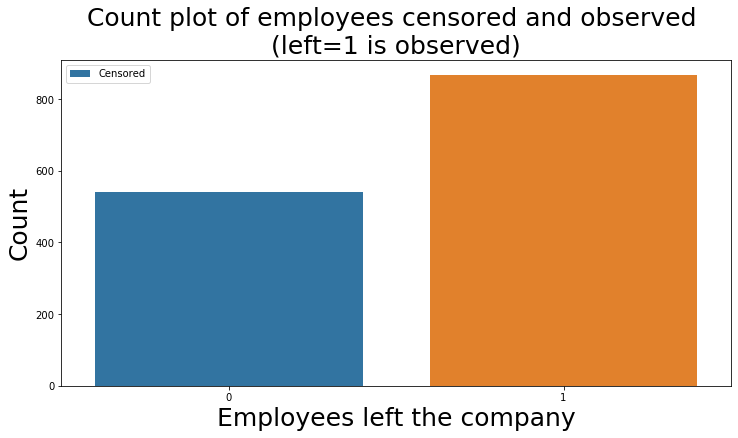

In [26]:
sns.countplot(data=data,x="left")
plt.legend(["Censored","Left the company"],loc="upper left")
plt.xlabel("Employees left the company",fontsize=25)
plt.ylabel("Count",fontsize=25)
plt.title("Count plot of employees censored and observed \n(left=1 is observed)",fontsize=25)

(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 <a list of 6 Text yticklabel objects>)

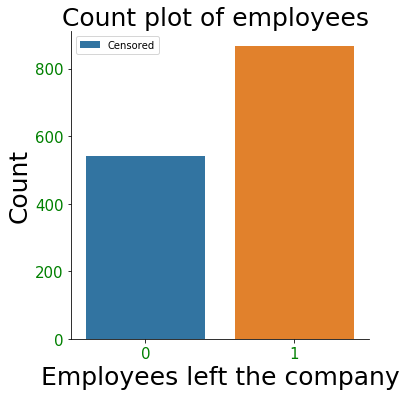

In [27]:
sns.catplot(data=data,x="left",kind="count")
# sns.countplot(data=data,x="left")
plt.legend(["Censored","Left the company"],loc="upper left")
plt.xlabel("Employees left the company",fontsize=25)
plt.ylabel("Count",fontsize=25)
plt.title("Count plot of employees ",fontsize=25)

plt.xticks(fontsize=15, color="green")
plt.yticks(fontsize=15 , color= "green")

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,
         800.]),
 <a list of 10 Text yticklabel objects>)

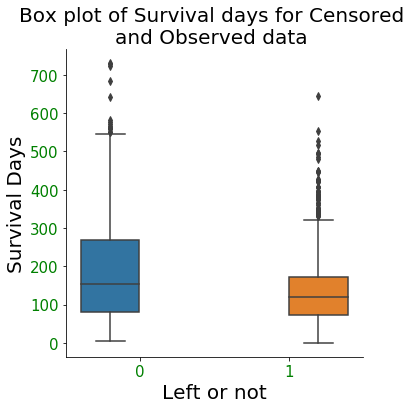

In [28]:
sns.catplot(hue="left", y="survival_days", x="left", kind="box", data=data)

plt.xlabel("Left or not",fontsize=20)
plt.ylabel("Survival Days",fontsize=20)
plt.title("Box plot of Survival days for Censored \nand Observed data ",fontsize=20)
plt.xticks(fontsize=15, color="green")
plt.yticks(fontsize=15 , color= "green")

Text(0.5, 1.0, 'Total number of employees who are censored or left the company after change in salary')

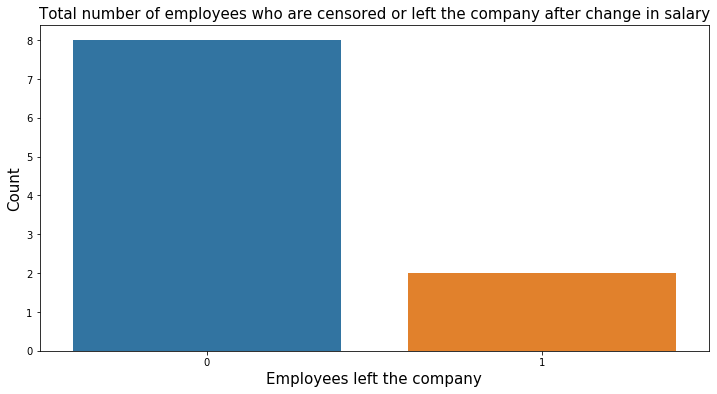

In [29]:
sns.countplot(data=change_in_salary,x="left")
plt.xlabel("Employees left the company",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.title("Total number of employees who are censored or left the company after change in salary",fontsize=15)

In [30]:
len(np.where(np.array(unq_sal)==2)[0])

10

In [31]:
(change_in_salary.left==1).sum()

2

Text(0.5, 1, 'Gender of total employees')

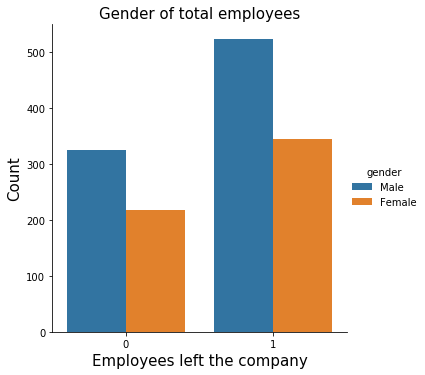

In [32]:
sns.catplot(data=data,x="left",hue="gender",kind="count")
plt.xlabel("Employees left the company",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.title("Gender of total employees",fontsize=15)

In [33]:
sum(np.logical_and(data.left==1,data.gender=="Female"))

344

(array([  0., 100., 200., 300., 400., 500., 600.]),
 <a list of 7 Text yticklabel objects>)

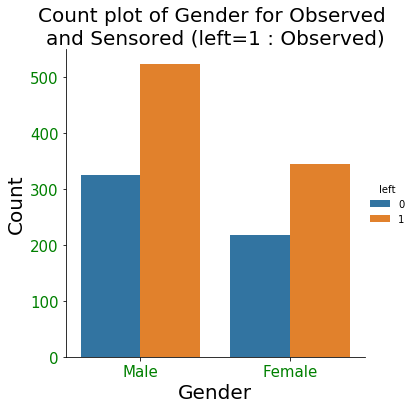

In [34]:
sns.catplot(data=data,x="gender",hue="left",kind="count")
plt.xlabel("Gender",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.title("Count plot of Gender for Observed \nand Sensored (left=1 : Observed)",fontsize=20)
plt.xticks(fontsize=15, color="green")
plt.yticks(fontsize=15 , color= "green")

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,
         800.]),
 <a list of 10 Text yticklabel objects>)

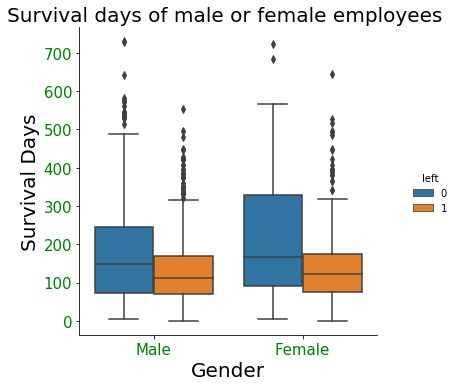

In [35]:
sns.catplot(hue="left", y="survival_days", x="gender", kind="box", data=data)

plt.xlabel("Gender",fontsize=20)
plt.ylabel("Survival Days",fontsize=20)
plt.title("Survival days of male or female employees ",fontsize=20)
plt.xticks(fontsize=15, color="green")
plt.yticks(fontsize=15 , color= "green")

In [36]:
# data["age"]=["young" if i<30 else "mature" if 30<= i < 40 else "aged" for i in data["age"]]

In [37]:
data.age.describe()

count       1409
unique         3
top       mature
freq         785
Name: age, dtype: object

(array([  0., 100., 200., 300., 400., 500., 600.]),
 <a list of 7 Text yticklabel objects>)

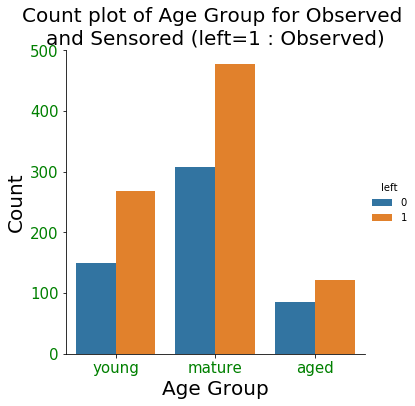

In [38]:
age_order=["young","mature","aged"] # , 
sns.catplot(data=data,x="age",hue="left",kind="count", order=age_order)
plt.xlabel("Age Group",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.title("Count plot of Age Group for Observed \nand Sensored (left=1 : Observed)",fontsize=20)
plt.xticks(fontsize=15, color="green")
plt.yticks(fontsize=15 , color= "green")

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,
         800.]),
 <a list of 10 Text yticklabel objects>)

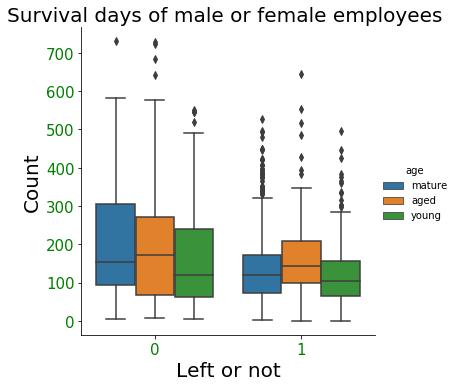

In [39]:
#age_order=["young","mature","aged"] # , order=age_order

sns.catplot(hue="age", y="survival_days", x="left", kind="box", data=data)
plt.xlabel("Left or not",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.title("Survival days of male or female employees ",fontsize=20)
plt.xticks(fontsize=15, color="green")
plt.yticks(fontsize=15 , color= "green")

# day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# sns.countplot(x = "Day", data = df, order = day_order)

In [40]:
## when age is continuous

# sns.catplot(hue="left", y="age", x="gender", kind="box", data=data)
# # plt.legend(title_fontsize="medium", shadow=True )
# plt.xlabel("Gender",fontsize=25)
# plt.ylabel("Age",fontsize=25)
# plt.title("Box plot of Age for Different Gender",fontsize=25)
# plt.xticks(fontsize=15, color="green")
# plt.yticks(fontsize=15 , color= "green")

(array([  0., 100., 200., 300., 400., 500., 600., 700., 800., 900.]),
 <a list of 10 Text yticklabel objects>)

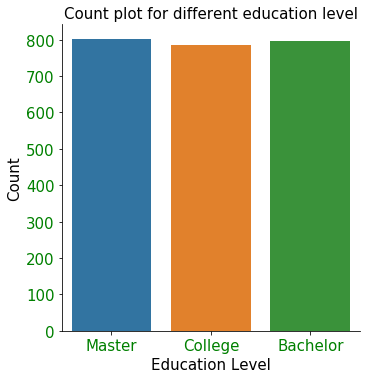

In [41]:
sns.catplot(data=cleaned_train_data,x="education_level",kind="count")
plt.xlabel("Education Level",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.title("Count plot for different education level",fontsize=15)
plt.xticks(fontsize=15, color="green")
plt.yticks(fontsize=15 , color= "green")

(array([  0.,  50., 100., 150., 200., 250., 300., 350.]),
 <a list of 8 Text yticklabel objects>)

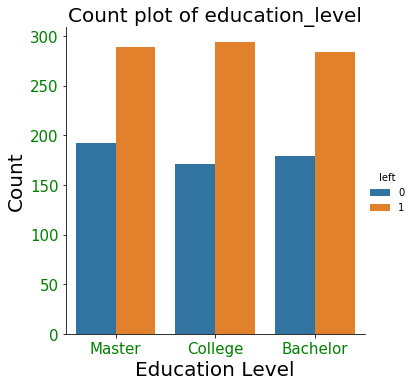

In [42]:
sns.catplot(data=data,x="education_level",hue="left",kind="count")
plt.xlabel("Education Level",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.title("Count plot of education_level",fontsize=20)
plt.xticks(fontsize=15, color="green")
plt.yticks(fontsize=15 , color= "green")

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,
         800.]),
 <a list of 10 Text yticklabel objects>)

<Figure size 1440x720 with 0 Axes>

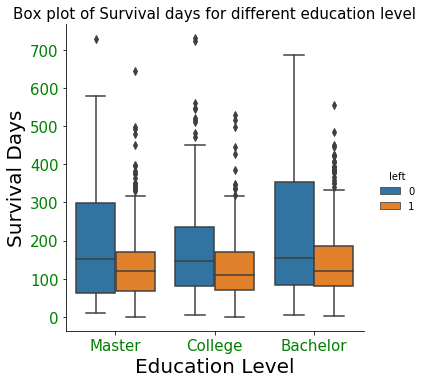

In [43]:
plt.figure(figsize=(20,10))
sns.catplot(hue="left", y="survival_days", x="education_level", kind="box", data=data)
plt.title("survival_days with education level and survival of the employee")
plt.xlabel("Education Level",fontsize=20)
plt.ylabel("Survival Days",fontsize=20)
plt.title("Box plot of Survival days for different education level",fontsize=15)

plt.xticks(fontsize=15, color="green")
plt.yticks(fontsize=15 , color= "green")

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,
         800.]),
 <a list of 10 Text yticklabel objects>)

<Figure size 1440x720 with 0 Axes>

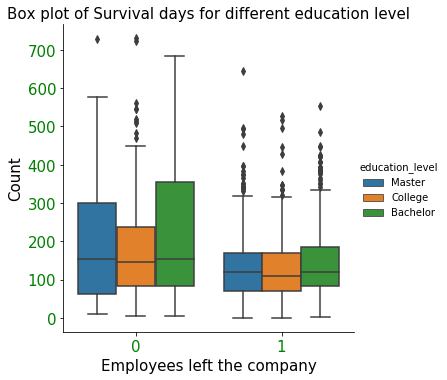

In [44]:
plt.figure(figsize=(20,10))
sns.catplot(hue="education_level", y="survival_days", x="left", kind="box", data=data)
plt.title("survival_days with education level and survival of the employee")
plt.xlabel("Employees left the company",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.title("Box plot of Survival days for different education level",fontsize=15)
plt.xticks(fontsize=15, color="green")
plt.yticks(fontsize=15 , color= "green")

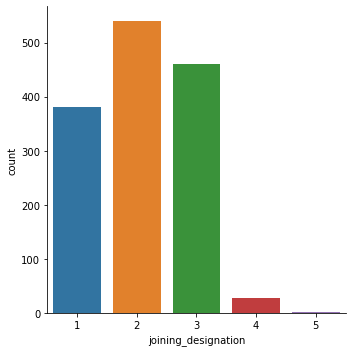

In [45]:
sns.catplot(data=data,x="joining_designation",kind="count")

In [46]:
data.joining_designation=data.joining_designation.apply(lambda x: 3 if x>3 else x)

/usr/lib/python3/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 <a list of 9 Text yticklabel objects>)

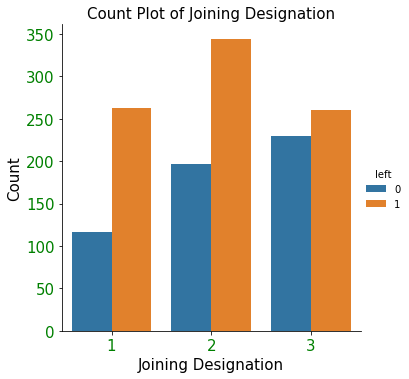

In [47]:
sns.catplot(data=data,x="joining_designation",hue="left",kind="count")
plt.title("survival_days with education level and survival of the employee")
plt.xlabel("Joining Designation",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.title("Count Plot of Joining Designation",fontsize=15)
plt.xticks(fontsize=15, color="green")
plt.yticks(fontsize=15 , color= "green")

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,
         800.]),
 <a list of 10 Text yticklabel objects>)

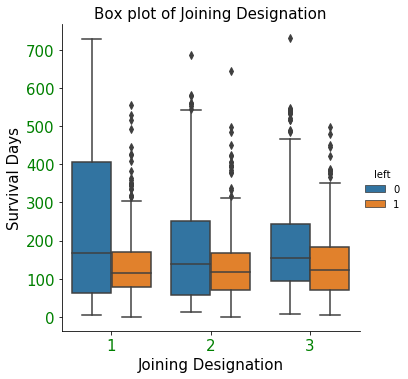

In [48]:
sns.catplot(x="joining_designation", y="survival_days", hue="left", kind="box", data=data)
plt.xlabel("Joining Designation",fontsize=15)
plt.ylabel("Survival Days",fontsize=15)
plt.title("Box plot of Joining Designation",fontsize=15)
plt.xticks(fontsize=15, color="green")
plt.yticks(fontsize=15 , color= "green")

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,
         800.]),
 <a list of 10 Text yticklabel objects>)

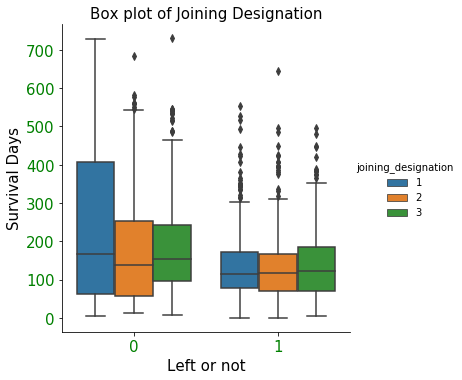

In [49]:
sns.catplot(hue="joining_designation", y="survival_days", x="left", kind="box", data=data)
plt.xlabel("Left or not",fontsize=15)
plt.ylabel("Survival Days",fontsize=15)
plt.title("Box plot of Joining Designation",fontsize=15)
plt.xticks(fontsize=15, color="green")
plt.yticks(fontsize=15 , color= "green")

In [50]:
[1,2,3,4,5,6][-3:]

[4, 5, 6]

In [51]:
# data["current_value"]=[0 if sum(data["total_business_val"][i][-1:])==0 else 1 for i in range(len(data))]

Text(0.5, 1, 'Distribution of employee having \nlast business value 0')

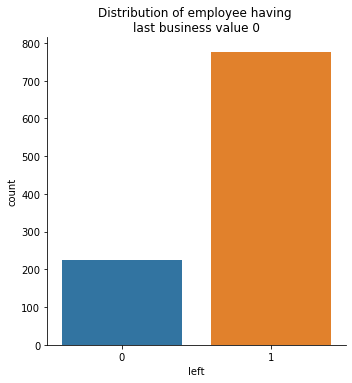

In [52]:
last_business_val_0=data[data["current_value"]==0]
sns.catplot(data=last_business_val_0,x="left",kind="count")
plt.title("Distribution of employee having \nlast business value 0")

Text(0.5, 1, 'Distribution of employee having \nlast business value other than 0')

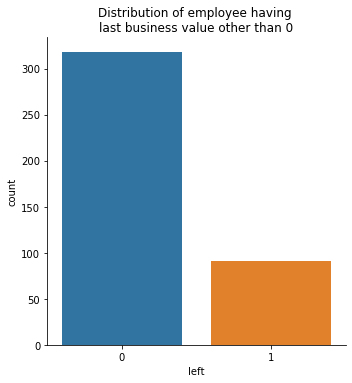

In [53]:
last_business_val_0=data[data["current_value"]==1]
sns.catplot(data=last_business_val_0,x="left",kind="count")
plt.title("Distribution of employee having \nlast business value other than 0")

# Modeling Using the processed data

## Data processing and storing for Time invariant cox model

In [54]:
# data.to_csv("not_left_truncated.csv",index=False)

In [55]:
##  create a dataframe
# df = pd.read_csv("./cleaned_csv1.csv") 
df=data.copy()
## First Have a look at the data
df.head(2)

,emp_id,age,gender,city,education_level,salary,avg_salary,dateofjoining,lastworking_date,survival_days,left,joining_designation,designation,average_business_value,total_business_val,total_quarter_rating,current_value,avg_rating
0,2,mature,Male,C7,Master,"[67016, 67016]",6.7016,2017-11-06,NaT,56.0,0,2,"[2, 2]",0.0,"[0, 0]","[1, 1]",0,1.0
1,4,aged,Male,C13,Master,"[65603, 65603, 65603, 65603, 65603]",6.5603,2016-12-07,2017-04-27,141.0,1,2,"[2, 2, 2, 2, 2]",0.7,"[0, 0, 0, 350000, 0]","[1, 1, 1, 1, 1]",0,1.0


In [56]:
df["joining_designation"]=[ str(i) for i in df.joining_designation]

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1409 entries, 0 to 1408
Data columns (total 18 columns):
emp_id                    1409 non-null int64
age                       1409 non-null object
gender                    1409 non-null object
city                      1409 non-null object
education_level           1409 non-null object
salary                    1409 non-null object
avg_salary                1409 non-null float64
dateofjoining             1409 non-null datetime64[ns]
lastworking_date          867 non-null datetime64[ns]
survival_days             1409 non-null float64
left                      1409 non-null int64
joining_designation       1409 non-null object
designation               1409 non-null object
average_business_value    1409 non-null float64
total_business_val        1409 non-null object
total_quarter_rating      1409 non-null object
current_value             1409 non-null int64
avg_rating                1409 non-null float64
dtypes: datetime64[ns](2), floa

In [58]:
# lst0=[]
# for i in range(len(df)):
#     stdt=df.iloc[i,7]
#     endt=df.iloc[i,8]
# #     print(endt)
# #     print(stdt)
#     if int(np.timedelta64(pd.Timestamp(stdt) - pd.Timestamp("2015-12-31") ,'D')/np.timedelta64(1,'D'))>0:
#         if endt!="nan":
#             lst0.append(int( np.timedelta64(pd.Timestamp("2018-01-01") - pd.Timestamp(stdt) ,'D') / np.timedelta64(1, 'D') )  )

#         else:
#             lst0.append(int(  np.timedelta64(pd.Timestamp(endt) - (pd.Timestamp(stdt)),'D') / np.timedelta64(1, 'D') ) )

#     else:
#         lst0.append("Left_side")
        
# df["survival_days"]=lst0

In [59]:
# df=df[df.survival_days!="Left_side"]
# df.head(2)

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.]),
 <a list of 10 Text yticklabel objects>)

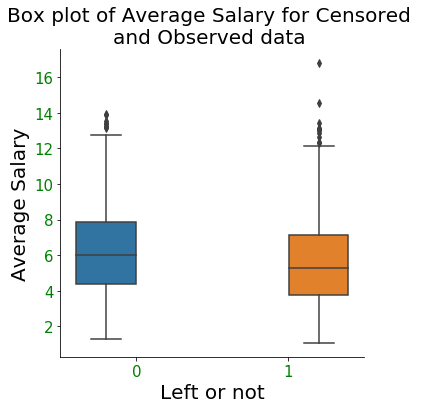

In [60]:
sns.catplot(hue="left", y="avg_salary", x="left", kind="box", data=data)

plt.xlabel("Left or not",fontsize=20)
plt.ylabel("Average Salary",fontsize=20)
plt.title("Box plot of Average Salary for Censored \nand Observed data ",fontsize=20)
plt.xticks(fontsize=15, color="green")
plt.yticks(fontsize=15 , color= "green")

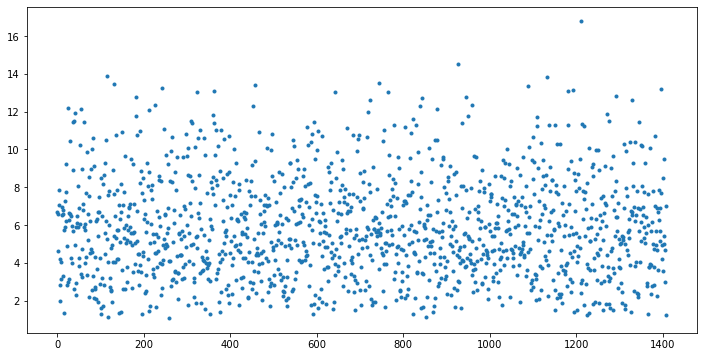

In [61]:
plot([i for i in range(len(df))],df.avg_salary,".")

In [62]:
# when the salary list became string

# lst=[]
# for i in df.salary:
#     lst.append(int(i[1:-1].split(",")[0])/10000)
# df.salary=lst

# df["avg_salary"]=[mean(df["salary"][i])/10000 for i in range(len(data))]

In [63]:
lst1=[]
for i in df.survival_days:
    j=i/30
#     if j-int(j)>0.5:
    j=int(j)+1
    if j==25:
        j=24
    lst1.append(int(j))
df["survival_months"]=lst1

In [64]:
# lst2=[]
# for i in df.joining_designation:
#     lst2.append(str(i))
# df.joining_designation=lst2

In [65]:
# df.drop("id",axis=1,inplace=True)
# df.drop("emp_id",axis=1,inplace=True)
# df.drop("city",axis=1,inplace=True)
# df.drop("dateofjoining",axis=1,inplace=True)
# df.drop("lastworking_date",axis=1,inplace=True)
# df.drop("total_business_val",axis=1,inplace=True)
# df.drop("average_business_value",axis=1,inplace=True)
# df.drop("total_quarter_rating",axis=1,inplace=True)


        8   lastworking_date        867 non-null    object 

        9   survival_days           1409 non-null   object 

In [66]:
df.drop(["emp_id","city","dateofjoining","lastworking_date","designation","total_business_val","survival_days","total_quarter_rating","salary"],axis=1,inplace=True)


In [67]:
cols = df.columns.tolist()
print(cols)
cols=cols[9:10]+cols[4:5]+cols[8:9]+cols[3:4]+cols[6:7]+cols[7:8]+cols[1:3]+cols[5:6]
print(cols)
df = df[cols]

['age', 'gender', 'education_level', 'avg_salary', 'left', 'joining_designation', 'average_business_value', 'current_value', 'avg_rating', 'survival_months']
['survival_months', 'left', 'avg_rating', 'avg_salary', 'average_business_value', 'current_value', 'gender', 'education_level', 'joining_designation']


In [68]:
print(len(df))
df.head()

1409


,survival_months,left,avg_rating,avg_salary,average_business_value,current_value,gender,education_level,joining_designation
0,2,0,1.0,6.7016,0.0000,0,Male,Master,2
1,5,1,1.0,6.5603,0.7000,0,Male,Master,2
2,2,1,1.0,4.6368,0.4012,0,Male,College,1
3,6,0,1.6,7.8728,2.5300,0,Female,Bachelor,3
4,2,1,1.0,7.0656,0.0000,0,Male,College,3


In [69]:
# # df.to_csv("cox_model.csv",index=False)
# df_1= pd.read_csv("cox_model.csv")
# df_1.head()

In [70]:
## Create a list of Categorical Columns
# cat_cols= [i  for i in df.columns if df[i].dtype==object]
# all_cols= [i  for i in df.columns]
# cat_cols.remove('customerID')  

In [71]:
## some columns have been removed because those are unique for all the rows.

# for i in ['Unnamed: 0', 'emp_id', 'age','salary', 'dateofjoining', 'lastworking_date', 'survival_days',
#        'designation','average_business_value', 'total_business_val', 'total_quarter_rating']:
#     all_cols.remove(i)  ## customerID has been removed because it is unique for all the rows.

In [72]:
## lets have a look at the categories and their distribution in all the categorical columns.

# for i in all_cols:
#     print('Column Name:',"``", i, "``", " which has", len(df[i].unique())  , "unique values")
#     print(df[i].value_counts())
#     print('-----------------------------')

# Kaplan Meier curve
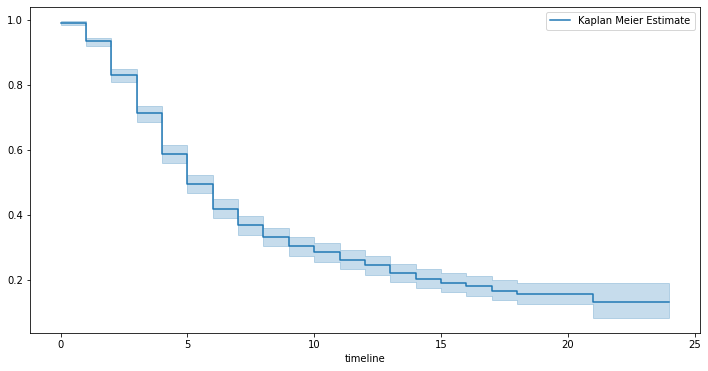

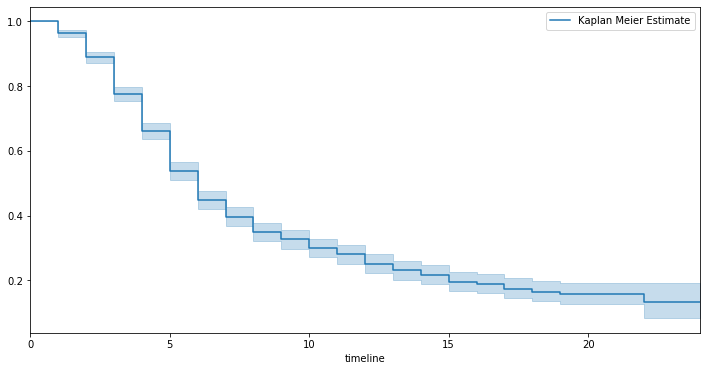

In [73]:
## Lets create an overall KaplanMeier curve, without breaking it into groups of covariates.

durations = df['survival_months'] ## Time to event data of censored and event data
event_observed = df['left']  ## It has the censored (1) and observed is (0)

## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
km.plot()

In [74]:
df.columns

Index(['survival_months', 'left', 'avg_rating', 'avg_salary',
       'average_business_value', 'current_value', 'gender', 'education_level',
       'joining_designation'],
      dtype='object')

In [75]:
df_kmf=pd.DataFrame({"Gender":df['gender'],"surv_month":df['survival_months'],"left":df["left"]})

In [76]:
df_kmf.Gender=df_kmf.Gender.apply(lambda x: 1 if x=="Male" else 0)

In [77]:
df_kmf=df_kmf.sort_values(by="surv_month").reset_index().drop(columns="index")

In [78]:
# df_kmf

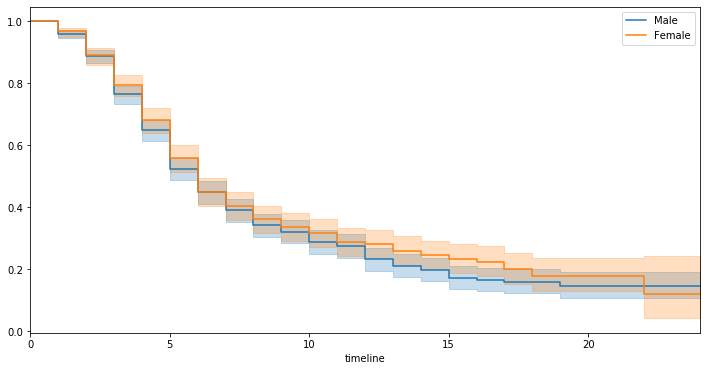

In [79]:
group1=df_kmf[df_kmf['Gender']==1]
group2=df_kmf[df_kmf['Gender']==0]
T=group1['surv_month']
E=group1['left']
T1=group2['surv_month']
E1=group2['left']

kmf=KaplanMeierFitter()
ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Male").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Female").plot(ax=ax)

In [80]:
from lifelines.statistics import logrank_test,multivariate_logrank_test

In [81]:
results=logrank_test(durations_A=T,durations_B=T1,event_observed_A=E,event_observed_B=E1)

In [82]:
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.61 0.21      2.28

In [83]:
# kmf1 = KaplanMeierFitter()

# T = df['survival_months'] 
# E = df['left']  

# ## Two Cohorts are compared. 
# groups = df['gender']   
# i1 = (groups == 'Male')      ## group i1 , having the pandas series for the 1st cohort
# i2 = (groups == 'Female')     ## group i2 , having the pandas series for the 2nd cohort

# ## fit the model for 1st cohort
# kmf1.fit(T[i1], E[i1], label='Male')
# a1 = kmf1.plot()

# ## fit the model for 2nd cohort
# kmf1.fit(T[i2], E[i2], label='Female')
# kmf1.plot(ax=a1)

In [84]:
df_edu_lvl=df[["survival_months","education_level","left"]]

In [85]:
df_edu_lvl=df_edu_lvl.sort_values("survival_months").reset_index(drop=True)

In [86]:
def edu_code(x):
    if x=="Bachelor":
        return 0
    elif x=="Master":
        return 1
    else:
        return 2

In [87]:
df_edu_lvl.education_level=df_edu_lvl.education_level.apply(edu_code)

In [88]:
results_edu=multivariate_logrank_test(df_edu_lvl["survival_months"],df_edu_lvl['education_level'],df_edu_lvl['left'])

In [89]:
results_edu.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           6.59 0.04      4.75

In [90]:
## Do a LOgRank test to justify that both the classes have a similar survival function

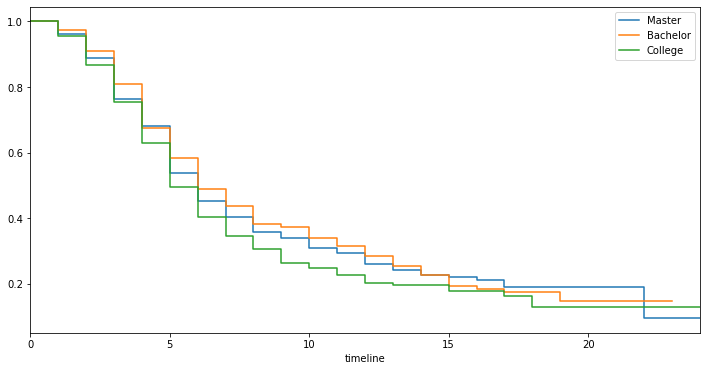

In [91]:
kmf2 = KaplanMeierFitter() 

T = df['survival_months']   
E = df['left']     

groups = df['education_level']             
ix1 = (groups == 'Master') 
ix2 = (groups == 'Bachelor')         
ix3 = (groups == 'College')        

kmf2.fit(T[ix1], E[ix1], label='Master')     
ax = kmf2.plot(ci_show=False)

kmf2.fit(T[ix2], E[ix2], label='Bachelor')          
ax1 = kmf2.plot(ax=ax,ci_show=False)

kmf2.fit(T[ix3], E[ix3], label='College')         
kmf2.plot(ax=ax1,ci_show=False)                                  

In [92]:
## Do same test here ALSO

In [93]:
df.joining_designation.unique()

array(['2', '1', '3'], dtype=object)

In [94]:
df.joining_designation=df.joining_designation.apply(str)

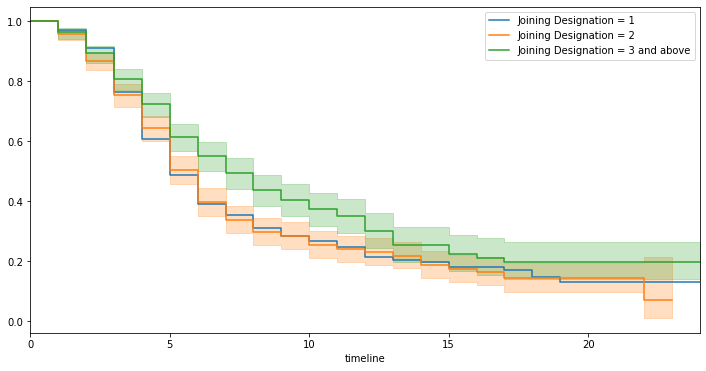

In [95]:
kmf3 = KaplanMeierFitter() 

T = df['survival_months']      
E = df['left']       

groups = df['joining_designation']   
i1 = (groups == "1")     
i2 = (groups == "2")    
i3 = (groups == "3")     
# i4 = (groups == "4")   
# i5 = (groups == "5")     

kmf3.fit(T[i1], E[i1], label='Joining Designation = 1')
a1 = kmf3.plot(ci_show=False)
kmf3.fit(T[i2], E[i2], label='Joining Designation = 2')
a2 = kmf3.plot(ax=a1)
kmf3.fit(T[i3], E[i3], label='Joining Designation = 3 and above')
a3 = kmf3.plot(ax=a2)
# kmf3.fit(T[i4], E[i4], label='groups == 4')
# a4 = kmf3.plot(ax=a3,ci_show=False)
# kmf3.fit(T[i5], E[i5], label='groups == 5')
# kmf3.plot(ax=a4,ci_show=False)

# plt.plot([0,25],[0,0])

In [96]:
df_joining=df[["survival_months","joining_designation","left"]]

In [97]:
results_joining=multivariate_logrank_test(df_joining["survival_months"],df['joining_designation'],df['left'])

In [98]:
results_joining

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          16.15 <0.005     11.65

In [99]:
sum([df.joining_designation=="5"])

0

In [100]:
df["joining_designation"]= df["joining_designation"].replace("5","4")

In [101]:
sum([df.joining_designation=="5"])

0

# Cox Proportional Hazard Model (Survival Regression)

In [102]:
df.columns

Index(['survival_months', 'left', 'avg_rating', 'avg_salary',
       'average_business_value', 'current_value', 'gender', 'education_level',
       'joining_designation'],
      dtype='object')

In [103]:
df_r= df.loc[:,:]
df_r.head() ## have a look at the data 

,survival_months,left,avg_rating,avg_salary,average_business_value,current_value,gender,education_level,joining_designation
0,2,0,1.0,6.7016,0.0000,0,Male,Master,2
1,5,1,1.0,6.5603,0.7000,0,Male,Master,2
2,2,1,1.0,4.6368,0.4012,0,Male,College,1
3,6,0,1.6,7.8728,2.5300,0,Female,Bachelor,3
4,2,1,1.0,7.0656,0.0000,0,Male,College,3


In [104]:
### Question????????????????????????????  why do we need to drop_first = True , at all do we need?

In [105]:
## Create dummy variables
df_dummy = pd.get_dummies(df_r, drop_first=True)
df_dummy.head()

,survival_months,left,avg_rating,avg_salary,average_business_value,current_value,gender_Male,education_level_College,education_level_Master,joining_designation_2,joining_designation_3
0,2,0,1.0,6.7016,0.0000,0,1,0,1,1,0
1,5,1,1.0,6.5603,0.7000,0,1,0,1,1,0
2,2,1,1.0,4.6368,0.4012,0,1,1,0,0,0
3,6,0,1.6,7.8728,2.5300,0,0,0,0,0,1
4,2,1,1.0,7.0656,0.0000,0,1,1,0,0,1


In [ ]:
# df_dummy.iloc[]

### Final corelation 

In [125]:
# plt.figure(figsize=(6,4))

# corr= df_dummy.dropna().corr()
# sns.heatmap(tech_rets_corr, annot=True, fmt='.2f')
# plt.show()

In [123]:
# corr_1= np.zeros([len(corr),len(corr)])
# for i in range(len(corr)):
#     for j in range(i+1):
#         a=corr.iloc[i,j]
#         if a>0.5 or a< -0.5 :
#             corr_1[i,j]= a
        

In [124]:
# high = pd.DataFrame(corr_1)
# plt.figure(figsize=(10,10))

# # tech_rets_corr= high.dropna().corr()
# sns.heatmap(high, annot=True, fmt='.2f')
# plt.show()

### Whole Model  

In [106]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(df_dummy, 'survival_months', event_col='left')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

<lifelines.CoxPHFitter: fitted with 1409 total observations, 542 right-censored observations>
             duration col = 'survival_months'
                event col = 'left'
      baseline estimation = breslow
   number of observations = 1409
number of events observed = 867
   partial log-likelihood = -5210.66
         time fit was run = 2022-02-25 09:59:53 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
avg_rating               -1.04       0.35       0.19            -1.40            -0.67                 0.25                 0.51
avg_salary               -0.01       0.99       0.02            -0.04             0.02                 0.96                 1.02
average_business_value   -0.12       0.89       0.04            -0.21            -0.03                 0.81                 0.97
current_value            -1.27       0.28       0.12            -1.51            -1.04                 0.22                 0.35
gender_Male               0.03       1.03       0.07            -0.11             0.16                 0.89                 1.18
education_level_College   0.04       1.05       0.08            -0.12             0.21                 0.89                 1.23
education_level_Master    0.14       1.15       0.08            -0.03             0.30                 0.97                 1.36
joining_designation_2    -0.03       0.97       0.09            -0.20             0.14                 0.82                 1.15
joining_designation_3    -0.25       0.78       0.12            -0.48            -0.02                 0.62                 0.98

                             z      p   -log2(p)
covariate                                       
avg_rating               -5.55 <0.005      25.08
avg_salary               -0.59   0.56       0.85
average_business_value   -2.72   0.01       7.24
current_value           -10.63 <0.005      85.26
gender_Male               0.36   0.72       0.48
education_level_College   0.53   0.60       0.74
education_level_Master    1.64   0.10       3.31
joining_designation_2    -0.33   0.74       0.43
joining_designation_3    -2.14   0.03       4.93
---
Concordance = 0.80
Partial AIC = 10439.32
log-likelihood ratio test = 812.68 on 9 df
-log2(p) of ll-ratio test = 559.42

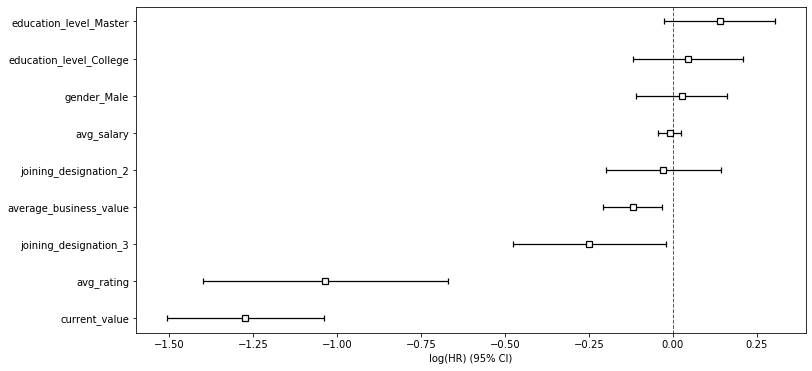

In [126]:
cph.plot()

In [135]:
# avg_rating                -0.974045
# avg_salary                -0.007772
# average_business_value    -0.104021
# current_value             -1.219619
# gender_Male                0.026638
# education_level_College    0.047647
# education_level_Master     0.125612
# joining_designation_2     -0.025181
# joining_designation_3     -0.216061
# dtype: float64

###  Prediction

In [136]:
# cph.variance_matrix_

In [137]:
# plt.figure(figsize=(15,15))
# sns.heatmap(cph.variance_matrix_, annot=True, fmt='.2f')
# plt.show()

In [138]:
## We want to see the Survival curve at the customer level. Therefore, we have selected 6 customers (rows 5 till 9).

tr_rows = df_dummy.iloc[6:16, 2:]
tr_rows

,avg_rating,avg_salary,average_business_value,current_value,gender_Male,education_level_College,education_level_Master,joining_designation_2,joining_designation_3
6,2.5,2.8116,4.345300,0,1,0,1,0,0
7,1.0,1.9734,0.000000,0,0,1,0,0,1
8,1.0,3.1631,0.000000,0,0,0,0,0,0
9,1.0,4.0342,0.000000,0,0,1,0,0,1
10,1.0,6.9457,0.000000,0,1,0,0,0,1
11,1.5,6.5189,1.584900,1,0,0,1,0,1
12,1.5,6.5813,1.190025,0,0,0,0,1,0
13,1.0,6.8070,1.000000,0,1,0,0,0,1
14,2.0,3.2865,3.055521,1,0,0,0,1,0
15,1.0,5.7375,1.083367,0,0,0,0,1,0


In [139]:
tr_rows.iloc[[0,8,9],:4]

,avg_rating,avg_salary,average_business_value,current_value
6,2.5,2.8116,4.345300,0
14,2.0,3.2865,3.055521,1
15,1.0,5.7375,1.083367,0


In [140]:
## Lets predict the survival curve for the selected employee. 
## Customers can be identified with the help of the number mentioned against each curve.
# cph.predict_survival_function(tr_rows).plot()

In [141]:
cph.predict_survival_function(tr_rows).head()

,6,7,8,9,10,11,12,13,14,15
1.0,0.991321,0.952599,0.942816,0.953551,0.955702,0.993006,0.971877,0.960585,0.996083,0.952263
2.0,0.972051,0.853915,0.825725,0.856693,0.862994,0.977435,0.911405,0.877417,0.987316,0.852938
3.0,0.938772,0.703277,0.652576,0.708387,0.720053,0.950399,0.813202,0.747152,0.971949,0.701485
4.0,0.896695,0.544723,0.478736,0.551572,0.567341,0.915949,0.699880,0.604690,0.952085,0.542329
5.0,0.838787,0.375535,0.304955,0.383177,0.400993,0.868014,0.562522,0.444404,0.923889,0.372878


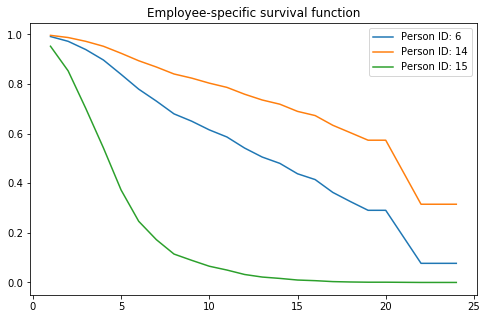

In [142]:
# As if I want to compare 2 different perdons Hazards function, now...
x=6       # the first person
y=14       # the 2nd person
z= 15
plt.figure(figsize=(8,5))
l=cph.predict_survival_function(tr_rows)[x]
l1=cph.predict_survival_function(tr_rows)[y]
l2=cph.predict_survival_function(tr_rows)[z]
plt.plot(l,label= "Person ID: " +str(x))
plt.plot(l1,label= "Person ID: " + str(y))
plt.plot(l2,label= "Person ID: " + str(z))
plt.title("Employee-specific survival function")
plt.legend()

In [143]:
# cph.score(rossi_train)
cph.score(df_dummy)

-3.698125416952334

In [147]:
#axes = cph.check_assumptions(df_dummy, show_plots=True)

# Measuring the Performance of Survival Models

In [148]:
#!pip install scikit-survival

In [149]:
df_dummy1= df_dummy.copy()
df_dummy1=df_dummy1.sort_values(by="survival_months", ascending=True)
df_dummy1.left= df_dummy1.left.apply(lambda x: True if x==1 else False)
a=df_dummy1.set_index(["left","survival_months"])
data_y=np.array(a.index, dtype=[('Status', '?'), ('Survival_in_months', '<f8')])

In [150]:
data_y

array([( True,  1.), ( True,  1.), ( True,  1.), ..., (False, 24.),
       (False, 24.), (False, 24.)],
      dtype=[('Status', '?'), ('Survival_in_months', '<f8')])

In [151]:
# data_y= np.zeros((len(df_dummy) , 2))
# rf.unstructured_to_structured(data_y)
# for i in range(len(df_dummy)):
#     data_y[i]= tuple( [df_dummy.iloc[i,1] , df_dummy.iloc[i,0]] )

In [152]:
data_x=df_dummy1.iloc[:,2:]

In [153]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)

CoxPHSurvivalAnalysis()

In [154]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_months"], prediction)
result[0]

0.8003304393413454

In [155]:
estimator.score(data_x, data_y)

0.8003304393413454

In [156]:
data_y["Survival_in_months"]

array([ 1.,  1.,  1., ..., 24., 24., 24.])

In [157]:
#list(prediction)

# Feature Selection: Which Variable is Most Predictive?

In [158]:
import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x.values, data_y)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

average_business_value     0.813212
avg_rating                 0.741244
current_value              0.676032
avg_salary                 0.562179
joining_designation_3      0.537836
education_level_College    0.523045
joining_designation_2      0.522168
gender_Male                0.511090
education_level_Master     0.502353
dtype: float64

In [159]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sksurv.preprocessing import OneHotEncoder



pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [160]:
pipe

Pipeline(steps=[('encode', OneHotEncoder()),
                ('select',
                 SelectKBest(k=3,
                             score_func=<function fit_and_score_features at 0x7f64facaddc0>)),
                ('model', CoxPHSurvivalAnalysis())])

In [161]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {'select__k': np.arange(1, data_x.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(data_x, data_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,3,{'select__k': 3},0.819668,0.824093,0.805752,0.816504,0.007815,1,0.815023,0.812795,0.822762,0.816860,0.004272
1,2,{'select__k': 2},0.811747,0.824460,0.804306,0.813504,0.008321,2,0.814016,0.808344,0.819117,0.813825,0.004400
0,1,{'select__k': 1},0.813448,0.823870,0.801650,0.812989,0.009077,3,0.812881,0.807869,0.818727,0.813159,0.004437
4,5,{'select__k': 5},0.807703,0.804190,0.803831,0.805242,0.001747,4,0.801761,0.807481,0.807948,0.805730,0.002813
3,4,{'select__k': 4},0.804370,0.805340,0.801843,0.803851,0.001474,5,0.801210,0.802953,0.808988,0.804384,0.003333
5,6,{'select__k': 6},0.800843,0.798888,0.803430,0.801054,0.001860,6,0.800940,0.804044,0.804668,0.803217,0.001630
6,7,{'select__k': 7},0.783816,0.789188,0.801783,0.791596,0.007530,7,0.798984,0.799915,0.804005,0.800968,0.002181
8,9,{'select__k': 9},0.781681,0.785279,0.802540,0.789833,0.009104,8,0.798434,0.799623,0.805991,0.801349,0.003318
7,8,{'select__k': 8},0.781901,0.780163,0.802406,0.788157,0.010101,9,0.798171,0.798933,0.804740,0.800615,0.002934


In [162]:
print(gcv.best_params_)

{'select__k': 3}


In [163]:
pipe.set_params(**gcv.best_params_)
pipe.fit(data_x, data_y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])


avg_rating               -0.855271
average_business_value   -0.131511
current_value            -1.225115
dtype: float64

In [ ]:
a=[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 22., 23., 24.]
b=[8.75460603e-01, 6.49235099e-01, 3.82498176e-01, 1.92205931e-01,
       7.13145108e-02, 2.44129041e-02, 9.85615936e-03, 3.47969254e-03,
       1.85334666e-03, 8.37452793e-04, 4.23253179e-04, 1.35679059e-04,
       4.94853848e-05, 2.28343693e-05, 6.08347254e-06, 2.91146767e-06,
       4.89363251e-07, 1.19917395e-07, 2.61240654e-08, 2.61240654e-08,
       2.31060224e-15, 2.31060224e-15, 2.31060224e-15]
plot(a,b)

In [ ]:
final_estimator.baseline_survival_

In [ ]:
df_dummy

In [165]:
tr_rows = df_dummy.iloc[6:16, [2,4,5]]
tr_rows

,avg_rating,average_business_value,current_value
6,2.5,4.345300,0
7,1.0,0.000000,0
8,1.0,0.000000,0
9,1.0,0.000000,0
10,1.0,0.000000,0
11,1.5,1.584900,1
12,1.5,1.190025,0
13,1.0,1.000000,0
14,2.0,3.055521,1
15,1.0,1.083367,0


In [166]:
h = h_0 * exp( sum(b_i * x_i))

NameError: name 'h_0' is not defined

/home/mahendra/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but CoxPHSurvivalAnalysis was fitted without feature names
  warnings.warn(


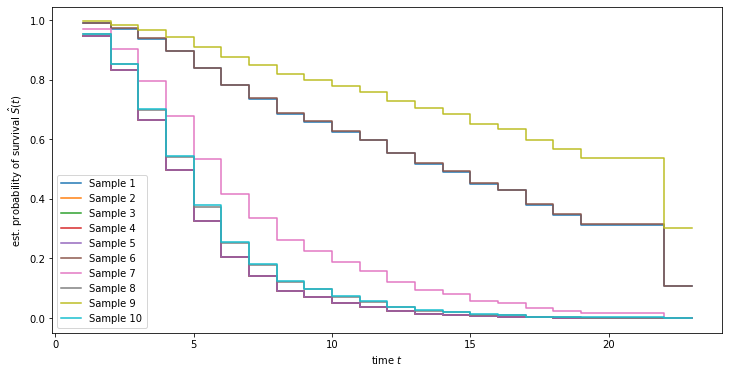

In [167]:
import numpy as np

pred_surv = final_estimator.predict_survival_function(tr_rows)
time_points = np.arange(1, 24)

for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [341]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)

CoxPHSurvivalAnalysis()

In [342]:
estimator.coef_

array([-0.9740447 , -0.00777166, -0.10402114, -1.21961928,  0.02663782,
        0.04764681,  0.12561226, -0.02518125, -0.21606102])

In [168]:
cph

<lifelines.CoxPHFitter: fitted with 1409 total observations, 542 right-censored observations>

In [ ]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x)
# result = concordance_index_censored(data_y["Status"], data_y["Survival_in_months"], prediction)
# result[0]

In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
estimator.fit(df_dummy.iloc[:,2:], data_y)

In [344]:
pd.Series(estimator.coef_, index=data_x.columns)

avg_rating                -0.974045
avg_salary                -0.007772
average_business_value    -0.104021
current_value             -1.219619
gender_Male                0.026638
education_level_College    0.047647
education_level_Master     0.125612
joining_designation_2     -0.025181
joining_designation_3     -0.216061
dtype: float64

# Time variant Model ( Cox proportional hazard )

#please prepare the data accordingly as required and shown in the ipynd named "practice"

#Refer to the link provided in wp. [Here it is](https://lifelines.readthedocs.io/en/latest/Time%20varying%20survival%20regression.html)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from lifelines.plotting import plot_lifetimes      # Lifeline package for the Survival Analysis
from lifelines.utils import to_long_format

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter 
from lifelines.utils import add_covariate_to_timeline
from lifelines.utils import covariates_from_event_matrix


%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


In [3]:
##  create a dataframe
df = pd.read_csv("./cleaned_csv1.csv") 
## Have a first look at the data
df.head(2)

,id,emp_id,age,gender,city,education_level,salary,dateofjoining,lastworking_date,survival_days,issurvived,joining_designation,designation,average_business_value,total_business_val,total_quarter_rating
0,0,1,28,Male,C23,Master,"[57387, 57387, 57387]",2015-12-24,2016-03-11,78,0,1,"[1, 1, 1]",1715580,"[2381060, -665480, 0]","[2, 2, 2]"
1,1,2,31,Male,C7,Master,"[67016, 67016]",2017-11-06,NaN,56,1,2,"[2, 2]",0,"[0, 0]","[1, 1]"


In [10]:
[i for i in df.columns]

['id',
 'emp_id',
 'age',
 'gender',
 'city',
 'education_level',
 'salary',
 'dateofjoining',
 'lastworking_date',
 'survival_days',
 'issurvived',
 'joining_designation',
 'designation',
 'average_business_value',
 'total_business_val',
 'total_quarter_rating']

In [11]:
df.describe(include= ['object', 'float', 'int'])

,id,emp_id,age,gender,city,education_level,salary,dateofjoining,lastworking_date,survival_days,issurvived,joining_designation,designation,average_business_value,total_business_val,total_quarter_rating
count,2381.000000,2381.000000,2381.000000,2381,2381,2381,2381,2381,1616,2381.000000,2381.000000,2381.000000,2381,2.381000e+03,2381,2381
unique,NaN,NaN,NaN,2,29,3,2377,869,493,NaN,NaN,NaN,89,NaN,1676,747
top,NaN,NaN,NaN,Male,C20,Master,"[52963, 52963]",2017-07-31,2017-07-29,NaN,NaN,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN,[0],"[1, 1, 1]"
freq,NaN,NaN,NaN,1404,152,802,2,31,70,NaN,NaN,NaN,162,NaN,176,242
mean,1190.000000,1397.559009,33.663167,NaN,NaN,NaN,NaN,NaN,NaN,437.438471,0.321294,1.820244,NaN,4.586742e+06,NaN,NaN
std,687.479818,806.161628,5.983375,NaN,NaN,NaN,NaN,NaN,NaN,567.733892,0.467071,0.841433,NaN,9.127115e+06,NaN,NaN
min,0.000000,1.000000,21.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,-1.385530e+06,NaN,NaN
25%,595.000000,695.000000,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,99.000000,0.000000,1.000000,NaN,0.000000e+00,NaN,NaN
50%,1190.000000,1400.000000,33.000000,NaN,NaN,NaN,NaN,NaN,NaN,192.000000,0.000000,2.000000,NaN,8.176800e+05,NaN,NaN
75%,1785.000000,2100.000000,37.000000,NaN,NaN,NaN,NaN,NaN,NaN,480.000000,1.000000,2.000000,NaN,4.173650e+06,NaN,NaN


In [5]:
type(df.salary[0])

str

In [12]:
df.salary.describe()

count               2381
unique              2377
top       [52963, 52963]
freq                   2
Name: salary, dtype: object

In [13]:
df.dtypes

id                         int64
emp_id                     int64
age                        int64
gender                    object
city                      object
education_level           object
salary                    object
dateofjoining             object
lastworking_date          object
survival_days              int64
issurvived                 int64
joining_designation        int64
designation               object
average_business_value     int64
total_business_val        object
total_quarter_rating      object
dtype: object

https://github.com/anurag-code/Survival-Analysis-Intuition-Implementation-in-Python/blob/master/Survival%20Analysis%20-%20Quick%20Implementation.ipynb